# Boltzmann Generators: Muller-Brown Potential

In [1]:
import sys
sys.path.append("../Library/simulations")
sys.path.append("../Library")

import simulation_library
import potentials
import integrators
import data_logging
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import visuals
import generator
import warnings
import torch 
from torch import distributions
from torch import nn
from torch.utils import data
from tqdm.auto import tqdm
from sklearn import datasets
# warnings.filterwarnings('ignore')

# torch.set_default_tensor_type('torch.cuda.FloatTensor')
plt.style.use("ggplot")
%matplotlib inline
system_builder = simulation_library.SystemFactory()

In [2]:
np.random.seed(seed=1)
torch.manual_seed(2)

## Potential

In [3]:
muller = potentials.MuellerPotential(alpha = 0.1,
                             A = [-200, -100, -170, 15],
                             a = [-1, -1, -6.5, 0.7],
                             b = [0, 0, 11, 0.6],
                             c = [-10, -10, -6.5, 0.7],
                             xj = [1, 0, -0.5, -1],
                             yj = [0, 0.5, 1.5, 1]
                            )

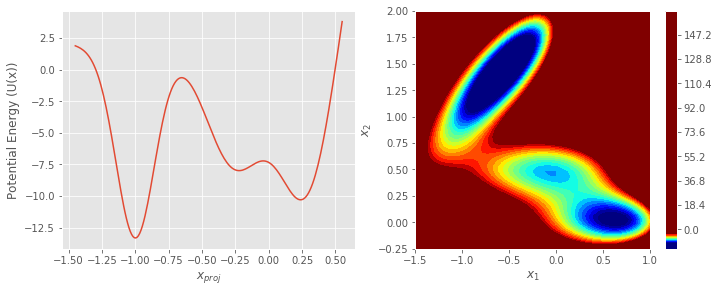

In [4]:
# Project xy coordinates to the (1, -1) vector
x_data = np.linspace(-1.2, 0.8, 200)
y_data = -x_data + 0.5
xy_data = np.array([x_data, y_data]).T
x_proj = np.dot(xy_data, np.array([1, -1]))/np.dot(np.array([1,-1]),np.array([1,-1]))

U = [muller(np.array([a,b])) for a,b in zip(x_data, y_data)]
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize=[10,4])
ax[0].plot(x_proj, U)
ax[0].set_xlabel("$x_{proj}$")
ax[0].set_ylabel("Potential Energy (U(x))")
visuals.plot_2D_potential(muller, xlim = [-1.5, 1], ylim = [-0.25, 2], cmap = 'jet')
fig.tight_layout(pad=0.5)

## Sampling

In [5]:
# Simulation Parameters
T = 1
sigma = 0.02 * np.sqrt(T)
x0_1 = np.array([-0.5,1.5])
x0_2 = np.array([-0.1, 0.5])
x0_3 = np.array([1.0, 0.0])
n_steps = 100000
out_freq = 100

In [6]:
# Sampling meta-state 1

# Build system 1
system_mp1 = simulation_library.System(dim = 2)
system_mp1.central_potential = muller
system_mp1.add_particle(simulation_library.Particle(None, x0_1))
system_mp1.get_integrator("metropolis", temp = T, sigma = sigma, adjust_sigma = False)
coords_logger_mp1 = data_logging.CoordinateLogger(system_mp1, out_freq)
energy_logger_mp1 = data_logging.EnergyLogger(system_mp1, out_freq)
system_mp1.registerObserver(coords_logger_mp1)
system_mp1.registerObserver(energy_logger_mp1)

# Simulate system 1
system_mp1.run(n_steps)

In [7]:
# Sampling meta-state 2

# Build system 2
system_mp2 = simulation_library.System(dim = 2)
system_mp2.central_potential = muller
system_mp2.add_particle(simulation_library.Particle(None, x0_2))
system_mp2.get_integrator("metropolis", temp = T, sigma = sigma, adjust_sigma = False)
coords_logger_mp2 = data_logging.CoordinateLogger(system_mp2, out_freq)
energy_logger_mp2 = data_logging.EnergyLogger(system_mp2, out_freq)
system_mp2.registerObserver(coords_logger_mp2)
system_mp2.registerObserver(energy_logger_mp2)

# Simulate system 2
system_mp2.run(n_steps)

In [8]:
# Sampling meta-state 3

# Build system 3
system_mp3 = simulation_library.System(dim = 2)
system_mp3.central_potential = muller
system_mp3.add_particle(simulation_library.Particle(None, x0_3))
system_mp3.get_integrator("metropolis", temp = T, sigma = sigma, adjust_sigma = False)
coords_logger_mp3 = data_logging.CoordinateLogger(system_mp3, out_freq)
energy_logger_mp3 = data_logging.EnergyLogger(system_mp3, out_freq)
system_mp3.registerObserver(coords_logger_mp3)
system_mp3.registerObserver(energy_logger_mp3)

# Simulate system 2
system_mp3.run(n_steps)

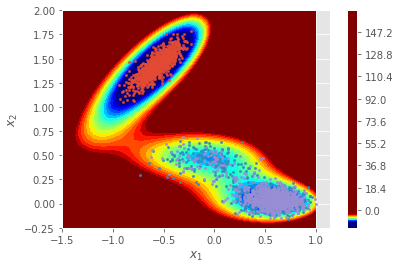

In [9]:
# Sampling on potential surface
visuals.plot_2D_potential(muller,  xlim = [-1.5, 1], ylim = [-0.25, 2], cmap="jet")
plt.scatter(*np.array(coords_logger_mp1.coordinates).T, s=5)
plt.scatter(*np.array(coords_logger_mp2.coordinates).T, s=5)
plt.scatter(*np.array(coords_logger_mp3.coordinates).T, s=5)

Text(0, 0.5, 'Potential Energy (U(x))')

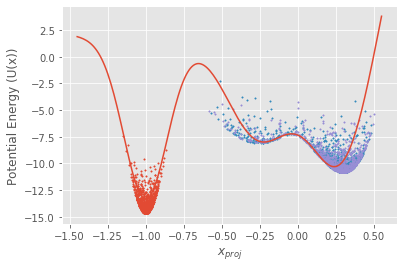

In [10]:
# Projecting samples to x_proj
xy_mp1 = np.array(coords_logger_mp1.coordinates).squeeze()
x_proj_mp1 = np.dot(xy_mp1, np.array([1, -1]))/np.dot(np.array([1, -1]), np.array([1, -1]))
xy_mp2 = np.array(coords_logger_mp2.coordinates).squeeze()
x_proj_mp2 = np.dot(xy_mp2, np.array([1, -1]))/np.dot(np.array([1, -1]), np.array([1, -1]))
xy_mp3 = np.array(coords_logger_mp3.coordinates).squeeze()
x_proj_mp3= np.dot(xy_mp3, np.array([1, -1]))/np.dot([1,-1],[1,-1])

# Energy Sampling
plt.plot(x_proj, U)
plt.scatter(x_proj_mp1, energy_logger_mp1.H, s=2)
plt.scatter(x_proj_mp2, energy_logger_mp2.H, s=2)
plt.scatter(x_proj_mp3, energy_logger_mp3.H, s=2)
plt.xlabel("$x_{proj}$")
plt.ylabel("Potential Energy (U(x))")

Text(0, 0.5, 'Frequency')

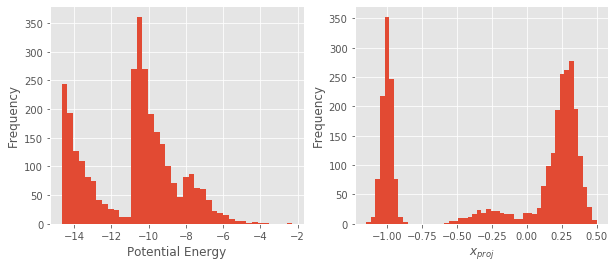

In [11]:
all_energy_mp = np.concatenate((energy_logger_mp2.H, energy_logger_mp1.H, energy_logger_mp3.H))
all_coords_mp = np.concatenate((x_proj_mp1, x_proj_mp2, x_proj_mp3))
fig, ax = plt.subplots(ncols=2, figsize=[10,4])
hist1 = ax[0].hist(all_energy_mp, bins = 40)
ax[0].set_xlabel("Potential Energy")
ax[0].set_ylabel("Frequency")
hist2 = ax[1].hist(all_coords_mp, bins = 50)
ax[1].set_xlabel("$x_{proj}$")
ax[1].set_ylabel("Frequency")

## Boltzmann Generator

In [12]:
# Dataset
x_samples = np.concatenate((xy_mp1, xy_mp2, xy_mp3))
np.random.shuffle(x_samples)

# RealNVP Parameters
n_blocks = 5  # number of NVP blocks (Divide by 2?)
dimension = 2    # dimensionality of the probability distributios (in real sapce and latent space)
n_hidden = 100   # number of nodes in each hidden layer
l_hidden = 3     # number of hidden layers 
n_iteration = 500
batch_size = 128
LR = 0.001     # learning rate

In [13]:
# NNetworks for transforming and scaling distributions
s_net = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2), nn.Tanh())
t_net = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2))
mask = torch.from_numpy(np.array([[0, 1], [1, 0]] * n_blocks).astype(np.float32)) 
prior = distributions.MultivariateNormal(torch.zeros(dimension), torch.eye(dimension)) 

ML loss: -12.7071027755737376


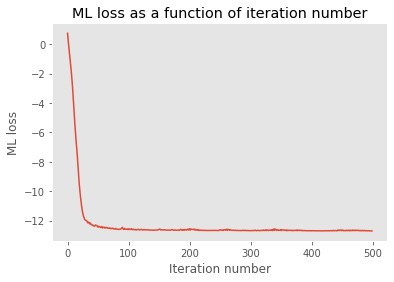

In [14]:
# torch.cuda.set_device(0)
model_ML = generator.RealNVP(s_net, t_net, mask, prior, system_mp1, (2,))
optimizer = torch.optim.Adam([p for p in model_ML.parameters() if p.requires_grad==True], lr=LR) 
training_set = x_samples.astype('float32')
subdata = data.DataLoader(dataset=training_set, batch_size=batch_size)  # use trainloader.dataset to check the data
batch = torch.from_numpy(subdata.dataset)  # note that subdata.dataset is a numpy array

loss_list = []   # saving the loss as a function of iteration number 
for i in tqdm(range(n_iteration)):
    loss = model_ML.loss_ML(batch)
    loss_list.append(loss.item())  # convert from 1-element tensor to scalar
    
    # start training
    optimizer.zero_grad() # Set grads to zero so that PyTorch will not accumulate gradients during backpropagation
    loss.backward(retain_graph=True)
    optimizer.step()   # check https://tinyurl.com/y8o2y5e7 for more info
    tqdm.write("ML loss: %s" % loss.item(), end="\r")

plt.figure()
plt.plot(range(n_iteration), loss_list)
plt.xlabel('Iteration number')
plt.ylabel('ML loss')
plt.title('ML loss as a function of iteration number')
plt.grid()

In [15]:
from scipy.stats import multivariate_normal
def binormal_contour():
    x, y = np.mgrid[-3:3:.01, -3:3:.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    rv = multivariate_normal([0, 0], [[1, 0], [0, 1]])
    
    plt.contourf(x, y, rv.pdf(pos), 20)
    plt.xlabel('$ z_{1} $')
    plt.ylabel('$ z_{2} $')
    plt.title('Bivariate normal distribution')
    clb = plt.colorbar()
    clb.ax.set_title(r'$P(z)$')
    
    ax = plt.gca()
    ax.set_aspect('equal')

/home/lenny/anaconda3/lib/python3.7/site-packages/torch/distributions/distribution.py:134: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


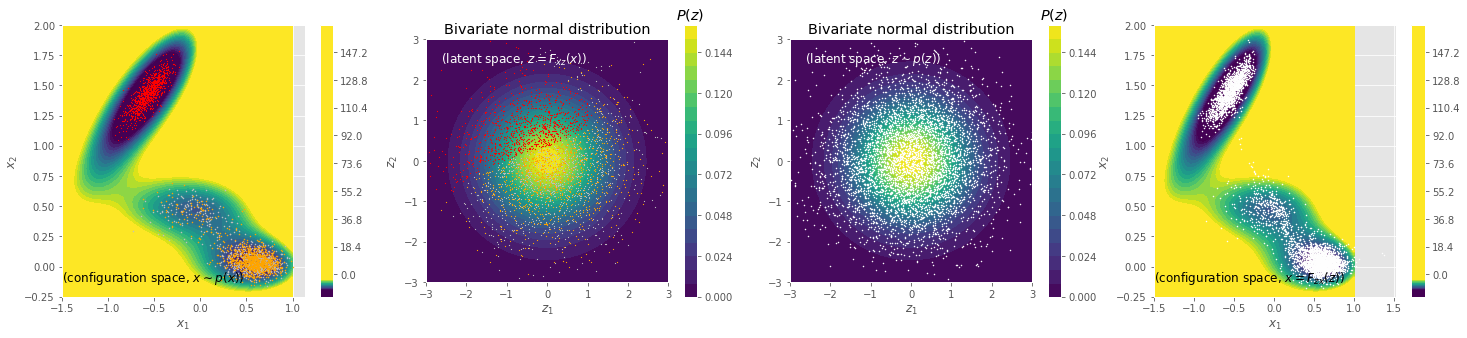

In [16]:
fig = plt.subplots(1, 4, figsize=(25, 5))

# First subplot: samples drawn from the configuration space
plt.subplot(1, 4, 1)
visuals.plot_2D_potential(muller, xlim = [-1.5, 1], ylim = [-0.25, 2])
plt.scatter(xy_mp1[:, 0], xy_mp1[:, 1], color='red', s=0.5)
plt.scatter(xy_mp2[:, 0], xy_mp2[:, 1], color='silver', s=1)
plt.scatter(xy_mp3[:, 0], xy_mp3[:, 1], color='orange', s=1)
plt.annotate('(configuration space, $ x \sim p(x) $)', xy=(0, 0), xytext=(-1.5, -0.125), color='black', size='12')
ax = plt.gca()


# Second subplot: transform configuration samples to latent samples using a trained inversed generator
z1 = model_ML.inverse_generator(torch.from_numpy(xy_mp1.astype('float32')))[0].detach().numpy()
z2 = model_ML.inverse_generator(torch.from_numpy(xy_mp2.astype('float32')))[0].detach().numpy()
z3 = model_ML.inverse_generator(torch.from_numpy(xy_mp3.astype('float32')))[0].detach().numpy()


plt.subplot(1, 4, 2)
binormal_contour()
plt.scatter(z1[:, 0], z1[:, 1], color='red', s=0.5)
plt.scatter(z2[:, 0], z2[:, 1], color='silver', s=0.5)
plt.scatter(z3[:, 0], z3[:, 1], color='orange', s=0.5)
plt.annotate('(latent space, $ z = F_{xz}(x) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])


# Third subplot: draw 2000 samples from the prior Gaussian distribution
z_samples = prior.sample_n(5000)
z_samples = z_samples.detach().numpy()  

plt.subplot(1, 4, 3)
binormal_contour()
plt.scatter(z_samples[:, 0], z_samples[:, 1], color='white', s=1)
plt.annotate('(latent space, $ z \sim p(z) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])

# fourth subplot: transform the latent samples back to the configuration space using a generator
x_generated, log_R_zx = model_ML.generator(torch.from_numpy(z_samples))
x_generated = x_generated.detach().numpy()

plt.subplot(1, 4, 4)
visuals.plot_2D_potential(muller, xlim = [-1.5, 1], ylim = [-0.25, 2])
plt.scatter(x_generated[:, 0], x_generated[:, 1], color='white', s=1)
plt.annotate('(configuration space, $ x = F_{zx}(z) $)', xy=(0, 0), xytext=(-1.5, -0.125), color='black', size='12')
ax = plt.gca()

# KL Loss

In [17]:
# RealNVP Parameters
n_blocks = 5  # number of NVP blocks (Divide by 2?)
dimension = 2    # dimensionality of the probability distributios (in real sapce and latent space)
n_hidden = 100   # number of nodes in each hidden layer
l_hidden = 3     # number of hidden layers 
n_iteration = 500
batch_size = 1000
LR = 0.001     # learning rate

In [18]:
# NNetworks for transforming and scaling distributions
s_net = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2), nn.Tanh())
t_net = lambda: nn.Sequential(nn.Linear(2, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, n_hidden), nn.ReLU(), nn.Linear(n_hidden, 2))
mask = torch.from_numpy(np.array([[0, 1], [1, 0]] * n_blocks).astype(np.float32)) 
prior = distributions.MultivariateNormal(torch.zeros(dimension), torch.eye(dimension)) 

KL loss: -18.830026626586914


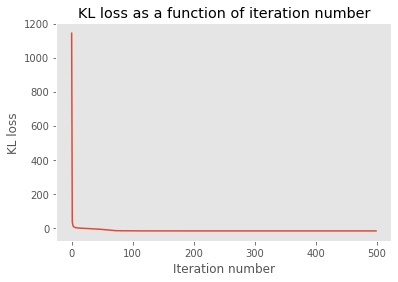

In [19]:
model_KL = generator.RealNVP(s_net, t_net, mask, prior, system_mp1, (2,))
# model_KL.cuda()
optimizer = torch.optim.Adam([p for p in model_KL.parameters() if p.requires_grad==True], lr=LR, amsgrad=False) 
z_samples = prior.sample_n(1000).detach().numpy()  
training_set = z_samples.astype('float32')   # note we use samples in latent space here
subdata = data.DataLoader(dataset=training_set, batch_size=batch_size)  # use trainloader.dataset to check the data
batch = torch.from_numpy(subdata.dataset)   # note that subdata.dataset is a numpy array

loss_list = []   # saving the loss as a function of iteration number 

for i in tqdm(range(n_iteration)):
    loss = model_KL.loss_KL(batch)  # note that batch here are the samples in the latent space!
    loss_list.append(loss.item())  # convert from 1-element tensor to scalar
    
    
    # start training
    optimizer.zero_grad() # Set grads to zero so that PyTorch will not accumulate gradients during backpropagation
    loss.backward(retain_graph=True)
    optimizer.step()   # check https://tinyurl.com/y8o2y5e7 for more info
    print("KL loss: %s" % loss.item(), end="\r")

plt.figure()
plt.plot(range(n_iteration), loss_list)
plt.xlabel('Iteration number')
plt.ylabel('KL loss')
plt.title('KL loss as a function of iteration number')
plt.grid()

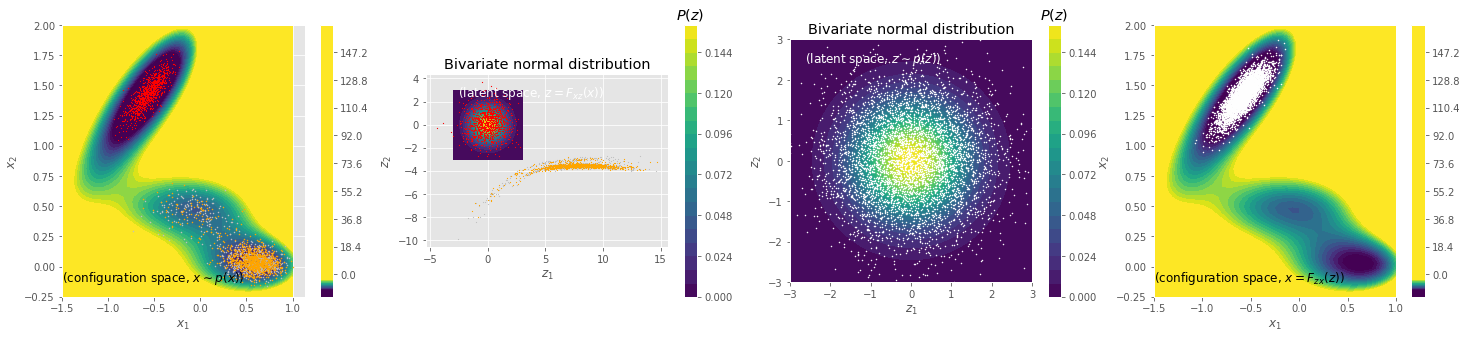

In [21]:
fig = plt.subplots(1, 4, figsize=(25, 5))

# First subplot: samples drawn from the configuration space
plt.subplot(1, 4, 1)
visuals.plot_2D_potential(muller, xlim = [-1.5, 1], ylim = [-0.25, 2])
plt.scatter(xy_mp1[:, 0], xy_mp1[:, 1], color='red', s=0.5)
plt.scatter(xy_mp2[:, 0], xy_mp2[:, 1], color='silver', s=1)
plt.scatter(xy_mp3[:, 0], xy_mp3[:, 1], color='orange', s=1)
plt.annotate('(configuration space, $ x \sim p(x) $)', xy=(0, 0), xytext=(-1.5, -0.125), color='black', size='12')
ax = plt.gca()


# Second subplot: transform configuration samples to latent samples using a trained inversed generator
z1 = model_KL.inverse_generator(torch.from_numpy(xy_mp1.astype('float32')))[0].detach().numpy()
z2 = model_KL.inverse_generator(torch.from_numpy(xy_mp2.astype('float32')))[0].detach().numpy()
z3 = model_KL.inverse_generator(torch.from_numpy(xy_mp3.astype('float32')))[0].detach().numpy()


plt.subplot(1, 4, 2)
binormal_contour()
plt.scatter(z1[:, 0], z1[:, 1], color='red', s=0.5)
plt.scatter(z2[:, 0], z2[:, 1], color='silver', s=0.5)
plt.scatter(z3[:, 0], z3[:, 1], color='orange', s=0.5)
plt.annotate('(latent space, $ z = F_{xz}(x) $)', xy=(0, 0),  xytext=(-2.625, 2.4375), color='white', size='12')
# plt.xlim([-3, 3])
# plt.ylim([-3, 3])


# Third subplot: draw 2000 samples from the prior Gaussian distribution
z_samples = prior.sample_n(5000)
z_samples = z_samples.detach().numpy()  

plt.subplot(1, 4, 3)
binormal_contour()
plt.scatter(z_samples[:, 0], z_samples[:, 1], color='white', s=1)
plt.annotate('(latent space, $ z \sim p(z) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])

# fourth subplot: transform the latent samples back to the configuration space using a generator
x_generated, log_R_zx = model_KL.generator(torch.from_numpy(z_samples))
x_generated = x_generated.detach().numpy()

plt.subplot(1, 4, 4)
visuals.plot_2D_potential(muller, xlim = [-1.5, 1], ylim = [-0.25, 2])
plt.scatter(x_generated[:, 0], x_generated[:, 1], color='white', s=1)
plt.annotate('(configuration space, $ x = F_{zx}(z) $)', xy=(0, 0),  xytext=(-1.5, -0.125), color='black', size='12')
ax = plt.gca()

# KL + ML Loss

In [ ]:
z_samples = prior.sample_n(5000)
z_samples = z_samples.detach().numpy()  

In [ ]:
model_KLML = generator.RealNVP(s_net, t_net, mask, prior, system_mp1, (2,))
# model_KLML.cuda()
optimizer = torch.optim.Adam([p for p in model_KLML.parameters() if p.requires_grad==True], lr=LR) 
training_set_x = x_samples.astype('float32')
training_set_z = z_samples.astype('float32')
subdata_x = data.DataLoader(dataset=training_set_x, batch_size=batch_size) 
subdata_z = data.DataLoader(dataset=training_set_z, batch_size=batch_size)  
batch_x = torch.from_numpy(subdata_x.dataset)   
batch_z = torch.from_numpy(subdata_z.dataset)
loss_list = []   # saving the loss as a function of iteration number 
for i in tqdm(range(n_iteration)):
    loss_ML = model_KLML.loss_ML(batch_x)
    loss_KL = model_KLML.loss_KL(batch_z)
    loss = loss_KL + loss_ML
    loss_list.append(loss.item())  # convert from 1-element tensor to scalar
    # start training
    optimizer.zero_grad() 
    loss.backward(retain_graph=True)
    optimizer.step()   # check https://tinyurl.com/y8o2y5e7 for more info
    print("ML loss: %s" % loss.item(), end="\r")

plt.figure()
plt.plot(range(n_iteration), loss_list)
plt.xlabel('Iteration number')
plt.ylabel('KL loss')
plt.title('KL loss as a function of iteration number')
plt.grid()

In [ ]:
fig = plt.subplots(1, 4, figsize=(25, 5))

# First subplot: samples drawn from the configuration space
plt.subplot(1, 4, 1)
visuals.plot_2D_potential(muller, xlim = [-1.5, 1], ylim = [-0.25, 2], cmap='jet')
plt.scatter(xy_mp1[:, 0], xy_mp1[:, 1], color='red', s=0.5)
plt.scatter(xy_mp2[:, 0], xy_mp2[:, 1], color='silver', s=1)
plt.scatter(xy_mp3[:, 0], xy_mp3[:, 1], color='orange', s=1)
plt.annotate('(configuration space, $ x \sim p(x) $)', xy=(0, 0), xytext=(-1.5, -0.125), color='black', size='12')
ax = plt.gca()


# Second subplot: transform configuration samples to latent samples using a trained inversed generator
z1 = model_KLML.inverse_generator(torch.from_numpy(xy_mp1.astype('float32')))[0].detach().numpy()
z2 = model_KLML.inverse_generator(torch.from_numpy(xy_mp2.astype('float32')))[0].detach().numpy()
z3 = model_KLML.inverse_generator(torch.from_numpy(xy_mp3.astype('float32')))[0].detach().numpy()


plt.subplot(1, 4, 2)
binormal_contour()
plt.scatter(z1[:, 0], z1[:, 1], color='red', s=0.5)
plt.scatter(z2[:, 0], z2[:, 1], color='silver', s=0.5)
plt.scatter(z3[:, 0], z3[:, 1], color='orange', s=0.5)
plt.annotate('(latent space, $ z = F_{xz}(x) $)', xy=(0, 0),  xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])


# Third subplot: draw 2000 samples from the prior Gaussian distribution
z_samples = prior.sample_n(5000)
z_samples = z_samples.detach().numpy()  

plt.subplot(1, 4, 3)
binormal_contour()
plt.scatter(z_samples[:, 0], z_samples[:, 1], color='white', s=1)
plt.annotate('(latent space, $ z \sim p(z) $)', xy=(0, 0), xytext=(-2.625, 2.4375), color='white', size='12')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.ylim([-3, 3])

# fourth subplot: transform the latent samples back to the configuration space using a generator
x_generated, log_R_zx = model_KLML.generator(torch.from_numpy(z_samples))
x_generated = x_generated.detach().numpy()

plt.subplot(1, 4, 4)
visuals.plot_2D_potential(muller, xlim = [-1.5, 1], ylim = [-0.25, 2], cmap='jet')
plt.scatter(x_generated[:, 0], x_generated[:, 1], color='white', s=1)
plt.annotate('(configuration space, $ x = F_{zx}(z) $)', xy=(0, 0),  xytext=(-1.5, -0.125), color='black', size='12')
ax = plt.gca()

## Free Energy Calculation

In [ ]:
z_f = prior.sample_n(50000)
x_f, log_R_zx = model_KLML.generator((z_f))
x_f = x_f.detach().numpy()
z_f

In [ ]:
u_x = model_KLML.calculate_energy(torch.from_numpy(x_f), space='configuration')
u_z = model_KLML.calculate_energy(z_f, space='latent')
w = torch.exp(-u_x + u_z + log_R_zx)
w = w.detach().numpy()

In [ ]:
x_proj.shape

In [ ]:
w.shape

In [ ]:
x_proj = np.dot(x_f, np.array([1, -1]))/np.dot(np.array([1,-1]),np.array([1,-1]))
counts, bins = np.histogram(x_proj, bins=200, weights=w)
probs = counts / np.sum(counts)  # p_x(x)
centers = np.array([0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])  # x

f = -np.log(probs)
f -= np.min(f)

plt.figure()
plt.scatter(centers, f, color = "blue", s = 3)
plt.xlabel("$x_{1}$")
plt.ylabel("Free energy $f$")
plt.title("Free energy as a function of $x_{1}$")
plt.grid()
#doublewell.plot_section(y=0)

f = -np.log(probs)
fn = f - np.min(f)

x_data = np.linspace(-1.2, 0.8, 200)
y_data = -x_data + 0.5
xy_data = np.array([x_data, y_data]).T
x_proj = np.dot(xy_data, np.array([1, -1]))/np.dot(np.array([1,-1]),np.array([1,-1]))

f_analyticals = []
for x,y in zip(x_data, y_data):
    f_analytical = muller(np.array([x,y])) - np.log(np.sqrt(np.pi))
    f_analytical += 13.75
    
    f_analyticals.append(f_analytical)

plt.plot(x_proj, f_analyticals)
plt.legend(["Analytical","Boltzman Generator"])

In [ ]:
x_data = np.linspace(-1.2, 0.8, 200)
y_data = -x_data + 0.5
xy_data = np.array([x_data, y_data]).T
x_proj = np.dot(xy_data, np.array([1, -1]))/np.dot(np.array([1,-1]),np.array([1,-1]))

U = [muller(np.array([a,b])) for a,b in zip(x_data, y_data)]